# Rotating FRC with 80nm Gold Beads sample

The rotating FRC method proposed in

*Nieuwenhuizen, Rpj, K. A. Lidke, and Mark Bates. 2013. “Measuring Image Resolution in Optical Nanoscopy.” Nature advance on (April). https://doi.org/10.1038/nmeth.2448.*

was used to analyze the same gold beads sample that was used in [Gold Beads FSC](http://localhost:8888/notebooks/notebooks/2018-05-01%20Gold%20Beads.ipynb) notebook.

In [11]:
%matplotlib inline
from ipywidgets import interact, fixed
from scipy import ndimage

import numpy as np

import os
import supertomo.ui.frc_options as options
from supertomo.ui.plots.image import display_2d_images
from supertomo.data.io import read
import supertomo.processing.image as imops
from supertomo.analysis.resolution.fourier_shell_correlation import DirectionalFSC
from supertomo.data.containers.image import Image
import supertomo.data.iterators.fourier_shell_iterators as iterators

def show_axial_slice(image1, image2, slice):
    display_2d_images(image1[slice], image2[slice])

## Test Data

A sample of 80nm sub-resolution gold beads was imaged in our custom laser-scanning confocal microscope. The fluorescence filter was removed from the confocal detector (APD) to allow the recording of laser reflection signal. 

Two stacks were acquired in line-by-line fashion to enable straightforward analysis with FSC.

In [12]:
# Image
data_dir = "/Users/sami/OneDrive - Fondazione Istituto Italiano Tecnologia/Microscopy/2018_04_FSC_measures_confocal"
image_name = "2018_04_23_80nm_Gold.tif"

# Get script options
args_list = [data_dir, '--bin-delta=10', '--frc-curve-fit-degree=4', 
            '--resolution-threshold-criterion=snr', '--resolution-snr-value=0.5',
            '--angle-delta=15', '--use-splines',
             '--resolution-point-sigma=0.001']
args = options.get_frc_script_options(args_list)

# Get image
image1 = read.get_image(os.path.join(data_dir, image_name), channel=0)
image2 = read.get_image(os.path.join(data_dir, image_name), channel=1)

#image1 = Image(np.transpose(image1, (0,2,1)), image1.spacing)
#image2 = Image(np.transpose(image2, (0,2,1)), image2.spacing)

# Pre-process
#image = imops.zoom_to_isotropic_spacing(image, order=0)
image1 = imops.zero_pad_to_cube(image1)
image2 = imops.zero_pad_to_cube(image2)

interact(show_axial_slice, image1=fixed(image1), image2=fixed(image2), slice=(0, image1.shape[0]-1))

interactive(children=(IntSlider(value=62, description=u'slice', max=124), Output()), _dom_classes=('widget-interact',))

<function __main__.show_axial_slice>

## Image registration

The two image stacks were registered for robust analysis (not very important)

Setting up registration job
Starting registration
Final metric value: -0.927193724988
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 15 iterations. Current step (0.000479957) is less than minimum step (0.0005).


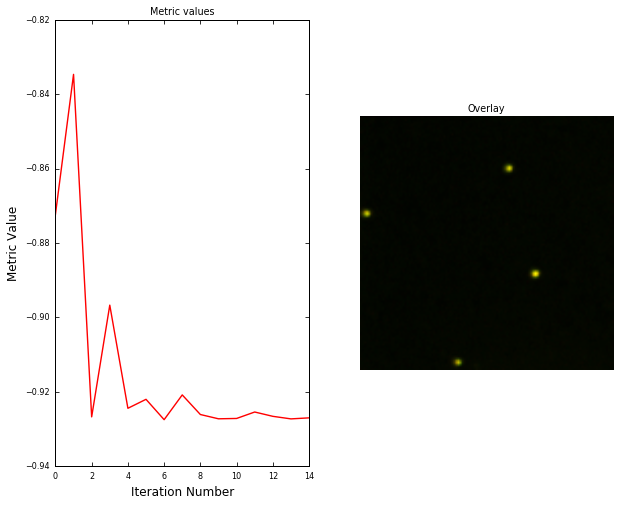

In [13]:
import SimpleITK as sitk

import supertomo.ui.supertomo_options as supertomo_options
from supertomo.processing.registration import registration
from supertomo.processing import itk

fixed_image = itk.convert_to_itk_image(image1)
moving_image = itk.convert_to_itk_image(image2)


args_list_2 = ("--sampling-percentage=.01 --reg-relax-factor=.6 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation " 
        "--reg-enable-observers").split()

registration_options = supertomo_options.get_debug_script_options(args_list_2)

transform = registration.itk_registration_rigid_3d(fixed_image, moving_image, registration_options)

image1 = itk.convert_from_itk_image(fixed_image)
image2 = itk.convert_from_itk_image(itk.resample_image(moving_image, transform))



In [14]:
#iterator = iterators.HollowConicalFourierShellIterator(image1.shape, args.d_bin, args.d_angle, args.d_extract_angle)

iterator = iterators.RotatingFourierShellIterator(image1.shape, args.d_bin, args.d_angle)


fsc_task = DirectionalFSC(image1, image2, iterator)
data = fsc_task.execute()

df = data.as_dataframe()

Angle
0      Axes(0.125,0.125;0.775x0.775)
15     Axes(0.125,0.125;0.775x0.775)
30     Axes(0.125,0.125;0.775x0.775)
45     Axes(0.125,0.125;0.775x0.775)
60     Axes(0.125,0.125;0.775x0.775)
75     Axes(0.125,0.125;0.775x0.775)
90     Axes(0.125,0.125;0.775x0.775)
105    Axes(0.125,0.125;0.775x0.775)
120    Axes(0.125,0.125;0.775x0.775)
135    Axes(0.125,0.125;0.775x0.775)
150    Axes(0.125,0.125;0.775x0.775)
165    Axes(0.125,0.125;0.775x0.775)
180    Axes(0.125,0.125;0.775x0.775)
195    Axes(0.125,0.125;0.775x0.775)
210    Axes(0.125,0.125;0.775x0.775)
225    Axes(0.125,0.125;0.775x0.775)
240    Axes(0.125,0.125;0.775x0.775)
255    Axes(0.125,0.125;0.775x0.775)
270    Axes(0.125,0.125;0.775x0.775)
285    Axes(0.125,0.125;0.775x0.775)
300    Axes(0.125,0.125;0.775x0.775)
315    Axes(0.125,0.125;0.775x0.775)
330    Axes(0.125,0.125;0.775x0.775)
345    Axes(0.125,0.125;0.775x0.775)
dtype: object

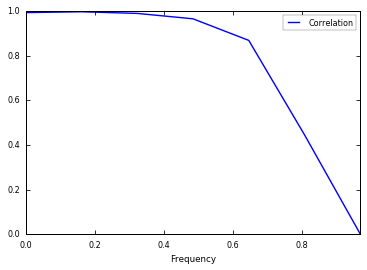

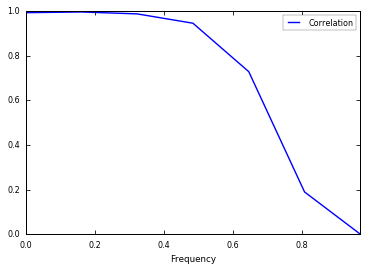

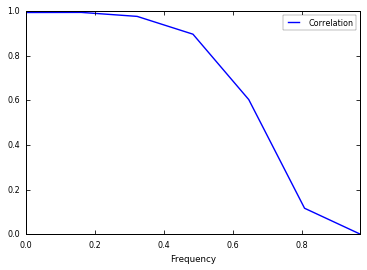

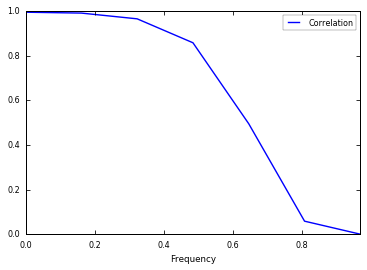

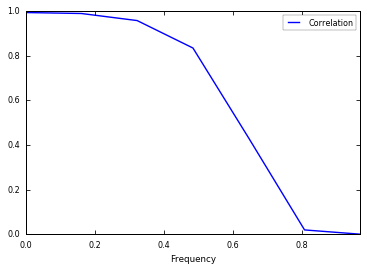

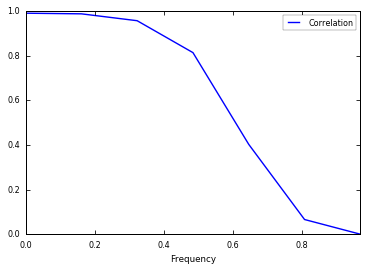

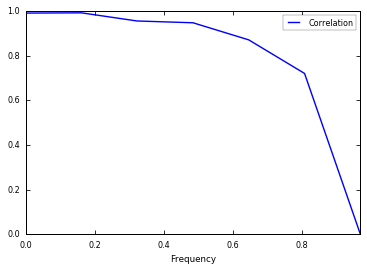

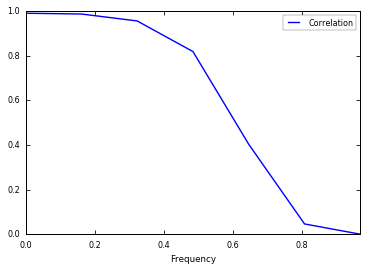

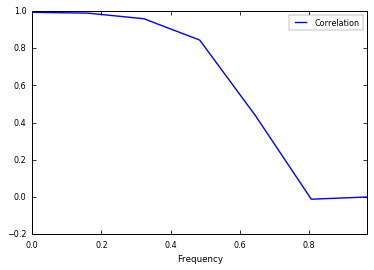

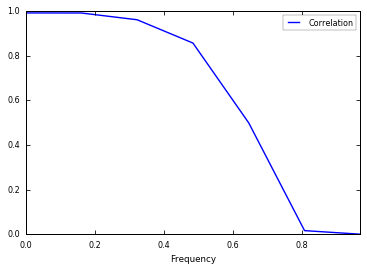

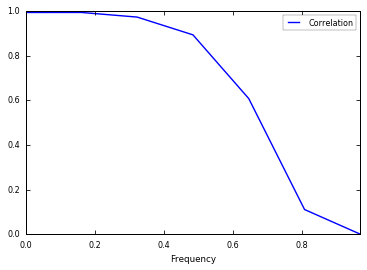

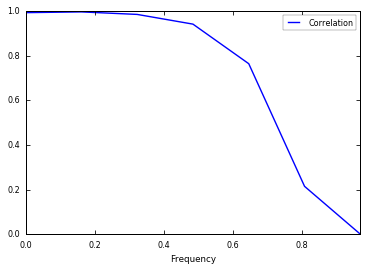

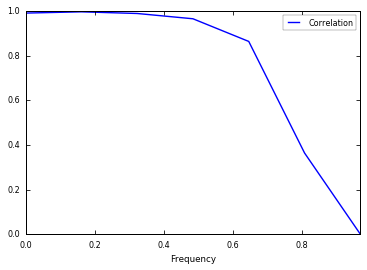

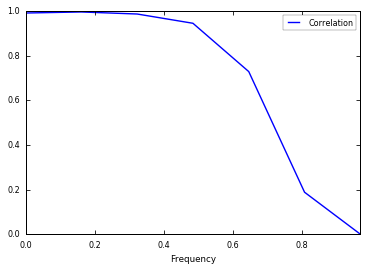

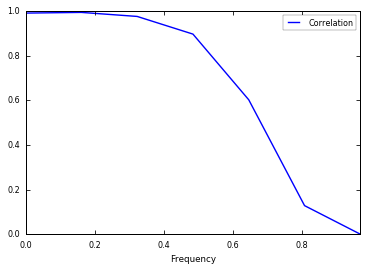

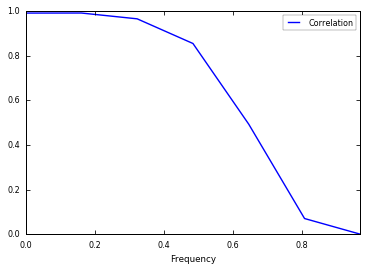

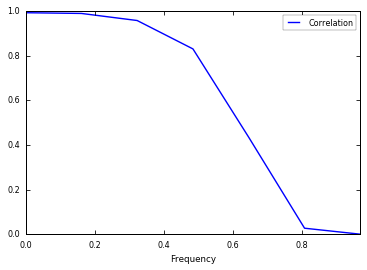

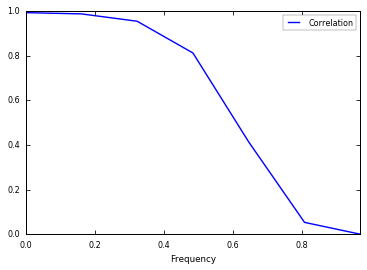

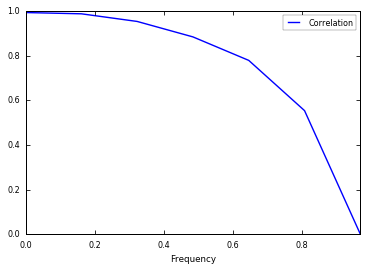

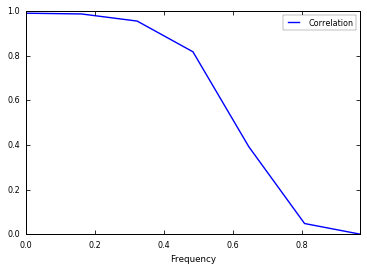

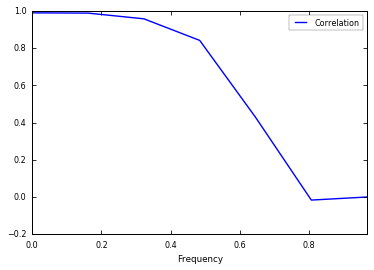

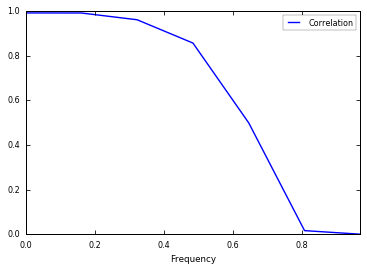

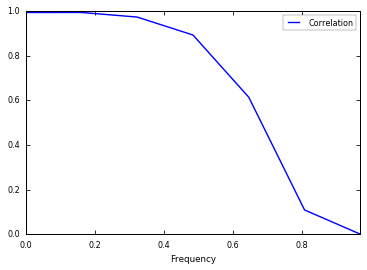

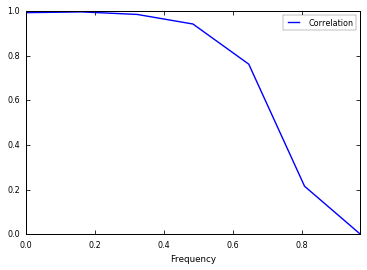

In [15]:
import matplotlib.pyplot as plt

df.groupby("Angle").plot(x='Frequency', y='Correlation')


In [16]:
import supertomo.analysis.resolution.analysis as fsc_analysis

analyzer = fsc_analysis.FourierCorrelationAnalysis(data, image1.spacing[0], args)
result = analyzer.execute()

Fit starts at 0.806451618671
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 13
         Function evaluations: 26
Fit starts at 0.806451618671
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 13
         Function evaluations: 26
Fit starts at 0.806451618671
Optimization terminated successfully.
         Current function value: 0.000093
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.806451618671
Optimization terminated successfully.
         Current function value: 0.000084
         Iterations: 12
         Function evaluations: 24
Fit starts at 0.645161271095
Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 12
         Function evaluations: 24
Fit starts at 0.806451618671
Optimization terminated successfully.
         Current function value: 0.000054
         Iterations: 12
         Function evaluations: 2

ValueError: A value in x_new is above the interpolation range.

## Results

While it is possible to obtain results with the method they are not very accurate. This is probably due to the extremely low signal level, especially in the axial direction, which makes the FRC calculation very unstable 

In [ ]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(result)
plotter.plot_polar()



In [ ]:
plotter.plot_all()